<h1> I. Beginning </h1>

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

pd.options.display.max_rows = 100

C:\Users\mszafraniec\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mszafraniec\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

## Import Data

In [3]:
train = pd.read_csv('./data/train.csv', sep = ",")
test = pd.read_csv('./data/test.csv', sep = ",")

In [4]:
dima_train = pd.read_csv('train_final_similarity.csv', index_col=0)
dima_test = pd.read_csv('test_final_similarity.csv', index_col=0)

In [5]:
train['similarity'] = dima_train
test['similarity'] = dima_test

In [6]:
IDtest = test['sample_id']
test.drop('sample_id',inplace=True,axis=1)

In [7]:
test.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity
0,50,1478104371,683078,82356,1,20021008,0,0,542,1,0,17698,2076,30,0.581670
1,2744,1479317140,876497,99692,1,19851231,0,0,307,1,0,10525,26,28,0.762971
2,2744,1479546361,876497,99692,1,19851231,0,0,307,1,0,8716,26,27,0.575178
3,2744,1478457729,876500,99692,1,19851231,2,1,265,1,0,5443,26,30,0.761683
4,2744,1480448560,876504,99692,1,19851231,2,1,356,1,0,7600,26,29,0.855453


In [8]:
train.describe()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,similarity
count,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06
mean,2.245030e+03,1.479011e+09,7.839624e+07,8.136169e+06,2.360018e+00,2.011388e+07,4.731900e-01,2.558086e-01,2.311527e+02,3.068742e-01,3.936884e-01,4.037300e+03,1.500740e+06,2.431278e+01,6.840330e-01,6.840322e-01
std,1.308979e+04,1.189935e+07,5.133633e+07,5.460090e+06,4.659856e+00,7.570138e+04,7.353008e-01,5.481663e-01,7.999463e+01,4.611968e-01,4.885672e-01,3.954754e+03,2.519546e+06,3.767797e+00,4.648999e-01,1.215231e-01
min,0.000000e+00,1.000000e+00,2.000580e+05,1.976000e+03,0.000000e+00,1.900010e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00,2.614927e-01
25%,0.000000e+00,1.478460e+09,1.376614e+07,1.255566e+06,0.000000e+00,2.009123e+07,0.000000e+00,0.000000e+00,1.960000e+02,0.000000e+00,0.000000e+00,8.990000e+02,2.605000e+03,2.100000e+01,0.000000e+00,6.075125e-01
50%,3.000000e+00,1.479057e+09,9.380660e+07,9.525626e+06,1.000000e+00,2.014103e+07,0.000000e+00,0.000000e+00,2.220000e+02,0.000000e+00,0.000000e+00,2.738000e+03,1.941720e+05,2.500000e+01,1.000000e+00,7.058671e-01
75%,2.700000e+01,1.479742e+09,1.262592e+08,1.329221e+07,2.000000e+00,2.016061e+07,1.000000e+00,0.000000e+00,2.540000e+02,1.000000e+00,1.000000e+00,6.064000e+03,1.519461e+06,2.800000e+01,1.000000e+00,7.754478e-01
max,2.597310e+05,1.480636e+09,1.372601e+08,1.472086e+07,7.300000e+01,3.000010e+07,2.000000e+00,2.000000e+00,6.553500e+04,1.000000e+00,1.000000e+00,1.991700e+04,1.144741e+07,3.000000e+01,1.000000e+00,9.186969e-01


### Take out absurd data

In [9]:
train.drop(train.index[(train['media_duration'] <= 30)*(train['is_listened'] == 1)], axis = 0, inplace = True)
train.drop(train.index[train['release_date'] > 30000000], axis = 0, inplace = True)

In [10]:
import time
import datetime
conv_date = lambda x: time.mktime(datetime.datetime.strptime(str(x)[:6], '%Y%m').timetuple())
train['release_date'] = (1000000 + train['release_date']).apply(conv_date) - 100*365.25*24*3600 #on rajoute et enleve 100 ans pour gerer les problemes d'overflow
test['release_date'] = (1000000 + test['release_date']).apply(conv_date) - 100*365.25*24*3600

In [11]:
train.drop(train.index[train['ts_listen'] > time.time()], axis = 0, inplace = True)
train.drop(train.index[train['ts_listen'] < 1230764491], axis = 0, inplace = True)
train.drop(train.index[train['release_date'] > time.time()], axis = 0, inplace = True)
# train.drop(train.index[train['ts_listen'] < train['release_date']], axis = 0, inplace = True) 28827 valeurs dans le train, 32 dans le test, presques toutes avec genre_id == 0

In [12]:
# not so bad anyways... - and none in the test
# len(train[train['ts_listen'] < 1230764491]) (= 631)

### Combined contains the common columns to the test and train set, in order to apply the same transformations on all the data

In [13]:
target = train['is_listened']
train.drop('is_listened', axis = 1, inplace = True)
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index', axis = 1, inplace = True)
combined = combined.join(target)
train['is_listened'] = target

In [14]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity,is_listened
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,9241,55164,29,0.296393,0.0
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,16547,55830,30,0.710089,1.0
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,7665,2704,29,0.591717,1.0
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,1580,938,30,0.359037,0.0
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0


In [15]:
# Took the data from "input.csv"

# How to process it?

# Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)
# Ts_listen, release_date: date under 2 different formats -> put to same format
# Context_type -> one-hot-encode
# Platform_name, platform_family -> one-hot encode? Aggregate?
# Media_duration -> this one seems simple, keep as is
# Listen_type -> probably keep as is, but not sure
# User_gender -> keep as is (sexism!)
# User_age -> keep as is

# Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 
# Using the date, we can compute the number of songs he listened in a row

# I think the key here is correctly using the information about artist, etc...


<h1> II. Feature Preparation </h1>

In [16]:
def medianNan(s):
    global combined
    combined[s].fillna(np.median(combined[~np.isnan(combined[s])][s]), inplace=True)

### Filling NaN values with the median of the column

In [17]:
# for s in combined.columns[1:]:
#     print(s,type(combined[s][0]))
#     medianNan(s)

### Dealing with categoricals

In [18]:
#categorical = ['platform_name', 'platform_family'] ## 'context_type' TOO BIG! (MemoryError)
categorical = []

In [19]:
def dummify(variable):
    global combined
    local_dummies = pd.get_dummies(combined[variable],prefix=variable)
    combined = pd.concat([combined,local_dummies],axis=1)
    combined.drop(variable,axis=1,inplace=True)

In [20]:
for s in categorical:
    dummify(s)

## DATA VISUALISATION

### Same user ID's in test and train

In [21]:
sorted(train['user_id'].unique()) == sorted(test['user_id'].unique())

True

### listen_type == 1 in test set (apart from one value)

In [22]:
sorted(test['listen_type'])[1]

1

<h1> III. Feature Engineering </h1>

## Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)

### Number of times an user has listened to a given song, artist etc?

In [23]:
def aggregation_functions(names, put_avrg = True, vincent = False):
    
    global combined
    global train
    
    name = '_'.join(names)
    
    
    count_ = train.groupby(names)[names[-1]].count()
    count_.name = 'count_' + name
    combined = combined.join(count_, names, 'left', 'l')
    combined['count_' + name].fillna(0, inplace=True)
    
    if put_avrg:
        avrg = train.groupby(names)['is_listened'].mean()
        avrg.name = 'avrg_listened_' + name + '_temp'
    
        if vincent:
            desc_name = count_.to_frame() #description table
            desc_name['avrg_listened'] = avrg.values

            for n in range(5,0,-1):  
                train_head = train.sort_values(names).groupby(names).head(n)
                avg_head = train_head.groupby(names)['is_listened'].mean()
                avg_head.name = 'avrg_head_'+str(n)
                desc_name = desc_name.join(avg_head)

            def predict_is_listened(row):
                count_name = row['count_' + name]
                if count_name > 5:
                    return row['avrg_listened']
                else: #estimate in the case of few lines
                    column_name = 'avrg_head_'+str(int(count_name))
                    return desc_name[desc_name[column_name] == row[column_name]]['avrg_listened'].median()

            desc_name['avrg_listened_'+str(name)+'_temp'] = desc_name.apply(lambda row: predict_is_listened(row),axis=1)

    #         combined = combined.join(avrg, names, 'left', 'l')
            combined = combined.join(desc_name['avrg_listened_'+str(name)+'_temp'], names, 'left', 'l')
    
        else:
            combined = combined.join(avrg, names, 'left', 'l')
    
        medianNan('avrg_listened_' + name + '_temp')
#         combined['avrg_listened_' + name + '_temp'].fillna(.5, inplace=True)

    
        combined['avrg_listened_' + name] = ((combined['avrg_listened_' + name + '_temp']*combined['count_' + name] - train['is_listened'])/(combined['count_' + name] - 1))[:len(train)].append(combined[len(train):]['avrg_listened_' + name + '_temp']) # Soooo smart
        combined['avrg_listened_' + name] /= (combined['count_' + name] >= 5)
        combined.drop('avrg_listened_' + name + '_temp', axis = 1, inplace = True)
        
    print(name, 'OK')
    

In [24]:
aggregation_functions(['user_id'], vincent = True)
aggregation_functions(['user_id', 'listen_type'], vincent = True)
aggregation_functions(['user_id', 'artist_id'], False)
aggregation_functions(['user_id', 'artist_id', 'listen_type'], False)
aggregation_functions(['user_id', 'media_id'], False)
aggregation_functions(['user_id', 'media_id', 'listen_type'], False)
aggregation_functions(['user_id', 'genre_id'])
aggregation_functions(['user_id', 'genre_id', 'listen_type'], False)
aggregation_functions(['context_type'])
aggregation_functions(['context_type', 'listen_type'])
aggregation_functions(['user_id', 'context_type'])
aggregation_functions(['user_id', 'context_type', 'listen_type'])

aggregation_functions(['user_id', 'platform_name'])
aggregation_functions(['user_id', 'platform_name', 'listen_type'])
aggregation_functions(['user_id', 'platform_name', 'context_type', 'listen_type'])
aggregation_functions(['user_id', 'platform_family'])
aggregation_functions(['user_id', 'platform_family', 'listen_type'])
aggregation_functions(['user_id', 'platform_family', 'context_type', 'listen_type'])

combined.replace([np.inf, -np.inf], np.nan, inplace=True)
medianNan('avrg_listened_user_id')
combined['avrg_listened_user_id_listen_type'].fillna(combined['avrg_listened_user_id'], inplace=True)
combined['avrg_listened_user_id_genre_id'].fillna(combined['avrg_listened_user_id'], inplace=True)
# combined['avrg_listened_user_id_genre_id_listen_type'].fillna(combined['avrg_listened_user_id_genre_id'], inplace=True)

medianNan('avrg_listened_context_type')
combined['avrg_listened_context_type_listen_type'].fillna(combined['avrg_listened_context_type'], inplace=True)
combined['avrg_listened_user_id_context_type'].fillna(combined['avrg_listened_context_type'], inplace=True)
combined['avrg_listened_user_id_context_type_listen_type'].fillna(combined['avrg_listened_user_id_context_type'], inplace=True)


medianNan('avrg_listened_user_id_platform_name')
combined['avrg_listened_user_id_platform_name_listen_type'].fillna(combined['avrg_listened_user_id_platform_name'], inplace=True)
combined['avrg_listened_user_id_platform_name_context_type_listen_type'].fillna(combined['avrg_listened_user_id_platform_name_listen_type'], inplace=True)

medianNan('avrg_listened_user_id_platform_family')
combined['avrg_listened_user_id_platform_family_listen_type'].fillna(combined['avrg_listened_user_id_platform_family'], inplace=True)
combined['avrg_listened_user_id_platform_family_context_type_listen_type'].fillna(combined['avrg_listened_user_id_platform_family_listen_type'], inplace=True)

user_id OK
user_id_listen_type OK
user_id_artist_id OK
user_id_artist_id_listen_type OK
user_id_media_id OK
user_id_media_id_listen_type OK
user_id_genre_id OK
user_id_genre_id_listen_type OK
context_type OK
context_type_listen_type OK
user_id_context_type OK
user_id_context_type_listen_type OK
user_id_platform_name OK
user_id_platform_name_listen_type OK
user_id_platform_name_context_type_listen_type OK
user_id_platform_family OK
user_id_platform_family_listen_type OK
user_id_platform_family_context_type_listen_type OK


In [25]:
np.sum(combined['avrg_listened_user_id'].isnull())

0

In [26]:
combined

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity,is_listened,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,count_context_type,avrg_listened_context_type,count_context_type_listen_type,avrg_listened_context_type_listen_type,count_user_id_context_type,avrg_listened_user_id_context_type,count_user_id_context_type_listen_type,avrg_listened_user_id_context_type_listen_type,count_user_id_platform_name,avrg_listened_user_id_platform_name,count_user_id_platform_name_listen_type,avrg_listened_user_id_platform_name_listen_type,count_user_id_platform_name_context_type_listen_type,avrg_listened_user_id_platform_name_context_type_listen_type,count_user_id_platform_family,avrg_listened_user_id_platform_family,count_user_id_platform_family_listen_type,avrg_listened_user_id_platform_family_listen_type,count_user_id_platform_family_context_type_listen_type,avrg_listened_user_id_platform_family_context_type_listen_type
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,9241,55164,29,0.296393,0.0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,58450,0.695615,58447,0.695599,10.0,0.444444,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,16547,55830,30,0.710089,1.0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,3197684,0.688475,3197382,0.688481,35.0,0.558824,35.0,0.558824,16.0,0.533333,15.0,0.571429,11.0,0.500000,16.0,0.533333,15.0,0.571429,11.0,0.500000
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,7665,2704,29,0.591717,1.0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,1617632,0.573599,1617587,0.573589,68.0,1.000000,68.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,1580,938,30,0.359037,0.0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,3197684,0.688476,3197382,0.688481,495.0,0.392713,495.0,0.392713,845.0,0.475118,551.0,0.438182,495.0,0.392713,1075.0,0.587523,781.0,0.603846,495.0,0.392713
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615
5,7,1478382544,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615
6,7,1478338409,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615
7,7,1478353709,542335,71718,1,1.201738e+09,1,0,150,1,1,10325,2939,29,0.789135,1.0,184,0.765027,100.0,0.717172,1.0,1.0,1.0,1.0,39.0,0.868421,23.0,1617632,0.573599,1617587,0.573589,97.0,0.708333,97.0,0.708333,143.0,0.711268,69.0,0.602941,69.0,0.602941,143.0,0.711268,69.0,0.602941,69.0,0.602941
8,7,1479130924,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615
9,7,1479214304,542335,71718,1,1.201738e+

### Compute age of song at the moment of listening (still some weird things on very few points...)

In [27]:
combined['age_song'] = combined['ts_listen'] - combined['release_date']

In [28]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity,is_listened,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,count_context_type,avrg_listened_context_type,count_context_type_listen_type,avrg_listened_context_type_listen_type,count_user_id_context_type,avrg_listened_user_id_context_type,count_user_id_context_type_listen_type,avrg_listened_user_id_context_type_listen_type,count_user_id_platform_name,avrg_listened_user_id_platform_name,count_user_id_platform_name_listen_type,avrg_listened_user_id_platform_name_listen_type,count_user_id_platform_name_context_type_listen_type,avrg_listened_user_id_platform_name_context_type_listen_type,count_user_id_platform_family,avrg_listened_user_id_platform_family,count_user_id_platform_family_listen_type,avrg_listened_user_id_platform_family_listen_type,count_user_id_platform_family_context_type_listen_type,avrg_listened_user_id_platform_family_context_type_listen_type,age_song
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,9241,55164,29,0.296393,0.0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,58450,0.695615,58447,0.695599,10.0,0.444444,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,392047215.0
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,16547,55830,30,0.710089,1.0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,3197684,0.688475,3197382,0.688481,35.0,0.558824,35.0,0.558824,16.0,0.533333,15.0,0.571429,11.0,0.500000,16.0,0.533333,15.0,0.571429,11.0,0.500000,339459935.0
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,7665,2704,29,0.591717,1.0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,1617632,0.573599,1617587,0.573589,68.0,1.000000,68.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,75481153.0
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,1580,938,30,0.359037,0.0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,3197684,0.688476,3197382,0.688481,495.0,0.392713,495.0,0.392713,845.0,0.475118,551.0,0.438182,495.0,0.392713,1075.0,0.587523,781.0,0.603846,495.0,0.392713,509883698.0
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,276631374.0


## Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 

### Time since previous song (what to do with the first value?)

In [29]:
combined_sorted = combined[['ts_listen', 'user_id', 'is_listened']].sort_values(['user_id', 'ts_listen'])

In [30]:
# ttnxt = -(combined_sorted - combined_sorted.shift(-1))
# ttnxt['ts_listen'].ix[ttnxt['user_id'] != 0] = np.nan
# ttnxt['ts_listen'].fillna(int(np.max(ttnxt[~np.isnan(ttnxt['ts_listen'])]['ts_listen'])), inplace=True)

In [31]:
ttprv = combined_sorted - combined_sorted.shift(1)
ttprv['ts_listen'].ix[ttprv['user_id'] != 0] = np.nan
ttprv['ts_listen'].fillna(int(np.max(ttprv[~np.isnan(ttprv['ts_listen'])]['ts_listen'])), inplace=True)

In [32]:
combined_sorted['time_to_prev'] = ttprv['ts_listen']
# combined_sorted['time_to_next'] = ttnxt['ts_listen']

In [33]:
combined_sorted.head()

,ts_listen,user_id,is_listened,time_to_prev
682395,1477939775,0,1.0,248904905.0
4454309,1477982531,0,1.0,42756.0
5353733,1477982561,0,0.0,30.0
5898585,1477982582,0,0.0,21.0
4715887,1477982792,0,1.0,210.0


## Compute the number of songs listened in a row

In [34]:
lintervals = [30, 60, 180, 300, 600, 1800, 3600, 12*3600, 24*3600]
for t in lintervals:    
    combined_sorted['just_after'] = (combined_sorted['time_to_prev'] < t)*(1-ttprv['user_id']).fillna(0) == 1

    combined_sorted['just_after2'] = combined_sorted['just_after'].cumsum()
    combined_sorted['just_after3'] = (1-combined_sorted['just_after'])*combined_sorted['just_after2'].shift(1)
    combined_sorted['just_after4'] = combined_sorted['just_after3'].cummax()
    combined_sorted['n_in_a_row_' + str(t)] = (combined_sorted['just_after2'] - combined_sorted['just_after4']).fillna(0)

combined_sorted.head()

,ts_listen,user_id,is_listened,time_to_prev,just_after,just_after2,just_after3,just_after4,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400
682395,1477939775,0,1.0,248904905.0,False,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4454309,1477982531,0,1.0,42756.0,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5353733,1477982561,0,0.0,30.0,True,2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
5898585,1477982582,0,0.0,21.0,True,3,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0
4715887,1477982792,0,1.0,210.0,True,4,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,4.0


In [35]:
combined_sorted['is_listened'].fillna(1, inplace = True)
for t in lintervals:    
    combined_sorted['just_after'] = (combined_sorted['time_to_prev'] < t)*(1-ttprv['user_id']).fillna(0)*combined_sorted['is_listened'] == 1

    combined_sorted['just_after2'] = combined_sorted['just_after'].cumsum()
    combined_sorted['just_after3'] = (1-combined_sorted['just_after'])*combined_sorted['just_after2'].shift(1)
    combined_sorted['just_after4'] = combined_sorted['just_after3'].cummax()
    combined_sorted['n_listened_in_a_row_' + str(t)] = ((combined_sorted['just_after2'] - combined_sorted['just_after4']).shift(1)*(1-ttprv['user_id'])).fillna(0)

combined_sorted

,ts_listen,user_id,is_listened,time_to_prev,just_after,just_after2,just_after3,just_after4,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400
682395,1477939775,0,1.0,248904905.0,False,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4454309,1477982531,0,1.0,42756.0,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5353733,1477982561,0,0.0,30.0,False,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5898585,1477982582,0,0.0,21.0,False,1,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4715887,1477982792,0,1.0,210.0,True,2,0.0,1.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2858809,1477982978,0,1.0,186.0,True,3,0.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,5.0,5.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3795467,1477983184,0,0.0,206.0,False,3,3.0,3.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,6.0,6.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
1209072,1477983362,0,1.0,178.0,True,4,0.0,3.0,0.0,0.0,1.0,6.0,6.0,6.0,6.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6887448,1477983546,0,1.0,184.0,True,5,0.0,3.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6713904,1477983730,0,1.0,184.0,True,6,0.0,3.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,9.0,9.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0


In [36]:
combined = combined.join(combined_sorted[['time_to_prev'] + ['n_in_a_row_' + str(t) for t in lintervals]  + ['n_listened_in_a_row_' + str(t) for t in lintervals]], None, 'left', 'l')

In [37]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity,is_listened,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,count_context_type,avrg_listened_context_type,count_context_type_listen_type,avrg_listened_context_type_listen_type,count_user_id_context_type,avrg_listened_user_id_context_type,count_user_id_context_type_listen_type,avrg_listened_user_id_context_type_listen_type,count_user_id_platform_name,avrg_listened_user_id_platform_name,count_user_id_platform_name_listen_type,avrg_listened_user_id_platform_name_listen_type,count_user_id_platform_name_context_type_listen_type,avrg_listened_user_id_platform_name_context_type_listen_type,count_user_id_platform_family,avrg_listened_user_id_platform_family,count_user_id_platform_family_listen_type,avrg_listened_user_id_platform_family_listen_type,count_user_id_platform_family_context_type_listen_type,avrg_listened_user_id_platform_family_context_type_listen_type,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,9241,55164,29,0.296393,0.0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,58450,0.695615,58447,0.695599,10.0,0.444444,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,392047215.0,12.0,3.0,7.0,25.0,25.0,25.0,25.0,25.0,42.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,16547,55830,30,0.710089,1.0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,3197684,0.688475,3197382,0.688481,35.0,0.558824,35.0,0.558824,16.0,0.533333,15.0,0.571429,11.0,0.500000,16.0,0.533333,15.0,0.571429,11.0,0.500000,339459935.0,194.0,0.0,0.0,0.0,8.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,7665,2704,29,0.591717,1.0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,1617632,0.573599,1617587,0.573589,68.0,1.000000,68.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,75481153.0,33.0,0.0,2.0,3.0,3.0,3.0,3.0,14.0,14.0,79.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,1580,938,30,0.359037,0.0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,3197684,0.688476,3197382,0.688481,495.0,0.392713,495.0,0.392713,845.0,0.475118,551.0,0.438182,495.0,0.392713,1075.0,0.587523,781.0,0.603846,495.0,0.392713,509883698.0,6.0,1.0,1.0,2.0,40.0,40.0,101.0,101.0,202.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,276631374.0,26052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,131.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0


## Compute the number of songs not listened in a row

In [38]:
for t in lintervals:    
    combined_sorted['just_after'] = (combined_sorted['time_to_prev'] < t)*(1-ttprv['user_id']).fillna(0)*(1-combined_sorted['is_listened']) == 1

    combined_sorted['just_after2'] = combined_sorted['just_after'].cumsum()
    combined_sorted['just_after3'] = (1-combined_sorted['just_after'])*combined_sorted['just_after2'].shift(1)
    combined_sorted['just_after4'] = combined_sorted['just_after3'].cummax()
    combined_sorted['n0_listened_in_a_row_' + str(t)] = ((combined_sorted['just_after2'] - combined_sorted['just_after4']).shift(1)*(1-ttprv['user_id'])).fillna(0)

combined_sorted

,ts_listen,user_id,is_listened,time_to_prev,just_after,just_after2,just_after3,just_after4,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400,n0_listened_in_a_row_30,n0_listened_in_a_row_60,n0_listened_in_a_row_180,n0_listened_in_a_row_300,n0_listened_in_a_row_600,n0_listened_in_a_row_1800,n0_listened_in_a_row_3600,n0_listened_in_a_row_43200,n0_listened_in_a_row_86400
682395,1477939775,0,1.0,248904905.0,False,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4454309,1477982531,0,1.0,42756.0,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5353733,1477982561,0,0.0,30.0,True,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5898585,1477982582,0,0.0,21.0,True,2,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4715887,1477982792,0,1.0,210.0,False,2,2.0,2.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2858809,1477982978,0,1.0,186.0,False,2,2.0,2.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,5.0,5.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3795467,1477983184,0,0.0,206.0,True,3,0.0,2.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,6.0,6.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1209072,1477983362,0,1.0,178.0,False,3,3.0,3.0,0.0,0.0,1.0,6.0,6.0,6.0,6.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6887448,1477983546,0,1.0,184.0,False,3,3.0,3.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6713904,1477983730,0,1.0,184.0,False,3,3.0,3.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,9.0,9.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
combined = combined.join(combined_sorted[['n0_listened_in_a_row_' + str(t) for t in lintervals]], None, 'left', 'l')
combined_sorted = None

In [40]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity,is_listened,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,count_context_type,avrg_listened_context_type,count_context_type_listen_type,avrg_listened_context_type_listen_type,count_user_id_context_type,avrg_listened_user_id_context_type,count_user_id_context_type_listen_type,avrg_listened_user_id_context_type_listen_type,count_user_id_platform_name,avrg_listened_user_id_platform_name,count_user_id_platform_name_listen_type,avrg_listened_user_id_platform_name_listen_type,count_user_id_platform_name_context_type_listen_type,avrg_listened_user_id_platform_name_context_type_listen_type,count_user_id_platform_family,avrg_listened_user_id_platform_family,count_user_id_platform_family_listen_type,avrg_listened_user_id_platform_family_listen_type,count_user_id_platform_family_context_type_listen_type,avrg_listened_user_id_platform_family_context_type_listen_type,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400,n0_listened_in_a_row_30,n0_listened_in_a_row_60,n0_listened_in_a_row_180,n0_listened_in_a_row_300,n0_listened_in_a_row_600,n0_listened_in_a_row_1800,n0_listened_in_a_row_3600,n0_listened_in_a_row_43200,n0_listened_in_a_row_86400
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,9241,55164,29,0.296393,0.0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,58450,0.695615,58447,0.695599,10.0,0.444444,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,392047215.0,12.0,3.0,7.0,25.0,25.0,25.0,25.0,25.0,42.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,16547,55830,30,0.710089,1.0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,3197684,0.688475,3197382,0.688481,35.0,0.558824,35.0,0.558824,16.0,0.533333,15.0,0.571429,11.0,0.500000,16.0,0.533333,15.0,0.571429,11.0,0.500000,339459935.0,194.0,0.0,0.0,0.0,8.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,7665,2704,29,0.591717,1.0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,1617632,0.573599,1617587,0.573589,68.0,1.000000,68.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,75481153.0,33.0,0.0,2.0,3.0,3.0,3.0,3.0,14.0,14.0,79.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,1580,938,30,0.359037,0.0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,3197684,0.688476,3197382,0.688481,495.0,0.392713,495.0,0.392713,845.0,0.475118,551.0,0.438182,495.0,0.392713,1075.0,0.587523,781.0,0.603846,495.0,0.392713,509883698.0,6.0,1.0,1.0,2.0,40.0,40.0,101.0,101.0,202.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,1812,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,998.0,0.933801,806.0,0.932919,754.0,0.929615,276631374.0,26052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,131.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,

# Nombre de fois ou la chanson a été écoutée dans les 50 dernières lignes

In [43]:
nlastlines = 50
combined_sorted = combined[['ts_listen', 'media_id', 'is_listened']].sort_values(['ts_listen'])
combined_sorted['nlastlines'] = sum([[i]*nlastlines for i in range(int(np.ceil(len(combined_sorted)//nlastlines))+1)], [])[:len(combined_sorted)]
avrg = combined_sorted.groupby(['media_id', 'nlastlines'])['is_listened'].mean()
avrg.name = 'avrg_listened_nlastlines_' + str(nlastlines)

combined = combined.join(combined_sorted['nlastlines'], None, 'left', 'l')
combined = combined.join(avrg, ['media_id', 'nlastlines'], 'left', 'l')
combined['avrg_listened_nlastlines_' + str(nlastlines)].fillna(.5, inplace=True)

In [44]:
combined

,genre_id,ts_listen,media_id,album_id,context_type,release_date,media_duration,listen_type,user_gender,user_id,artist_id,user_age,similarity,is_listened,platform_name_0,platform_name_1,platform_name_2,platform_family_0,platform_family_1,platform_family_2,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,count_context_type,avrg_listened_context_type,count_context_type_listen_type,avrg_listened_context_type_listen_type,count_user_id_context_type,avrg_listened_user_id_context_type,count_user_id_context_type_listen_type,avrg_listened_user_id_context_type_listen_type,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400,n0_listened_in_a_row_30,n0_listened_in_a_row_60,n0_listened_in_a_row_180,n0_listened_in_a_row_300,n0_listened_in_a_row_600,n0_listened_in_a_row_1800,n0_listened_in_a_row_3600,n0_listened_in_a_row_43200,n0_listened_in_a_row_86400,nlastlines,avrg_listened_nlastlines_50
0,25471,1480597215,222606,41774,12,1.088550e+09,223,0,0,9241,55164,29,0.308638,0.0,0,1,0,1,0,0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,58450,0.695615,58447,0.695599,10.0,0.444444,10.0,0.444444,3.920472e+08,12.0,3.0,7.0,25.0,25.0,25.0,25.0,25.0,42.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,150846,0.0
1,25571,1480544735,250467,43941,0,1.141085e+09,171,0,0,16547,55830,30,0.880730,1.0,0,0,1,0,1,0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,3197684,0.688475,3197382,0.688481,35.0,0.558824,35.0,0.558824,3.394599e+08,194.0,0.0,0.0,0.0,8.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149889,1.0
2,16,1479563953,305197,48078,1,1.404083e+09,149,1,1,7665,2704,29,0.847618,1.0,0,0,1,0,1,0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,1617632,0.573599,1617587,0.573589,68.0,1.000000,68.0,1.000000,7.548115e+07,33.0,0.0,2.0,3.0,3.0,3.0,3.0,14.0,14.0,79.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104704,1.0
3,7,1480152098,900502,71521,0,9.702684e+08,240,0,1,1580,938,30,0.308638,0.0,1,0,0,1,0,0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,3197684,0.688476,3197382,0.688481,495.0,0.392713,495.0,0.392713,5.098837e+08,6.0,1.0,1.0,2.0,40.0,40.0,101.0,101.0,202.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,133677,0.0
4,7,1478368974,542335,71718,0,1.201738e+09,150,0,1,1812,2939,24,0.747038,1.0,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,2.766314e+08,26052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,131.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31594,1.0
5,7,1478382544,542335,71718,0,1.201738e+09,150,0,1,1812,2939,24,0.747038,1.0,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,2.766449e+08,148.0,0.0,0.0,1.0,11.0,13.0,13.0,13.0,40.0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,32881,1.0
6,7,1478338409,542335,71718,0,1.201738e+09,150,0,1,1812,2939,24,0.747038,1.0,1,0,0,1,0,0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,2.766008e+08,148.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,113.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28092,1.0
7,7,1478353709,542335,7

## Date and time

### Hourly average...

In [40]:
def create_column_date(combined):
    combined['date'] = pd.to_datetime(combined['ts_listen'],unit='s')
    return combined

combined = create_column_date(combined)

In [ ]:
train['hour'] = combined[:len(train)]['date'].dt.hour
combined['hour'] = combined['date'].dt.hour
avg_is_listened_per_hour = train.groupby(['hour'])['is_listened'].mean()
avg_is_listened_per_hour.name = 'avg_per_hour'
combined = combined.join(avg_is_listened_per_hour, 'hour', 'left')

combined.drop('date',axis=1,inplace=True)

In [ ]:
newtrain = combined[:len(target)]
newtrain['is_listened'] = target
newtest = combined[len(target):]

In [ ]:
plt.plot(newtrain.groupby(['n_in_a_row_3600'])['is_listened'].mean())
plt.xlim(xmax = 80)

## Average length of series

In [41]:
import itertools 

def get_mean_durations(bits):
    durations_ones = [sum(g) for b, g in itertools.groupby(bits) if b]
    durations_zeros = [sum(g) for b, g in itertools.groupby(1-bits) if b]
    
    if len(durations_ones) == 0:
        mean_durations_ones = 0
    else:
        mean_durations_ones = np.mean(durations_ones)
    
    if len(durations_zeros) == 0:
        mean_durations_zeros = 0
    else:
        mean_durations_zeros = np.mean(durations_zeros)  
    
    return mean_durations_ones, mean_durations_zeros

In [42]:
def survival_probability(bits):
    
    if len(bits) == 1:
        return np.nan, np.nan
    
    if len(np.unique(bits[:-1])) == 1: #bits is a constant series
        if len(np.unique(bits)) == 1:
            if np.unique(bits) == np.array([0]): #bits is a constant series, equal to 0
                return 1,np.nan

            else: #np.unique(bits) == np.array([1]): #bits is a constant series, equal to 1
                return np.nan,1

        else:
            if np.unique(bits[:-1]) == np.array([0]): #case [0,0,0,...,0,0,1]
                return (len(bits) - 2) / (len(bits) - 1), np.nan
            else: #np.unique(bits[:-1]) == np.array([1]): #case [1,1,1,...,1,1,0]
                return np.nan, (len(bits) - 2) / (len(bits) - 1)
    
    #Now, case where 'everything is fine': there are 0 and 1
    diff = bits[1:] - bits[:-1]
    mult = bits[:-1] * bits[1:]
    transitions_all = diff + 2*mult
    
    count_0 = list(transitions_all).count(0) #transition 0->0
    count_1 = list(transitions_all).count(1) #transition 0->1
    count_2 = list(transitions_all).count(2) #transition 1->1
    count_minus1 = list(transitions_all).count(-1) #transition 1->0
    
    survival_probability_0 = count_0 / (count_0 + count_1) #proba, given x_t = 0, of having x_t+1 = 0
    survival_probability_1 = count_2 / (count_2 + count_minus1) #proba, given x_t = 1, of having x_t+1 = 1
    return survival_probability_0, survival_probability_1

In [43]:
# survival = pd.DataFrame(columns=('user_id', 'svp_0', 'svp_1', 'md_1', 'md_0'))
survival = []
for user, group in train.sort_values('ts_listen').groupby(['user_id']):
    #the variable "group" is all the songs that the user listened to
    binary_list = group.sort_values('ts_listen')['is_listened'].values    
    survival += [np.append(user, np.ravel(np.array((survival_probability(binary_list), get_mean_durations(binary_list)))))]
    
survival = np.vstack(survival)

In [44]:
svdf = pd.DataFrame(survival)
svdf.columns = ['user_id', 'svp_0', 'svp_1', 'md_1', 'md_0']
combined = combined.join(svdf, 'user_id', 'left', 'l')

combined['svp_0'] /= combined['count_user_id'] > 5
combined['svp_1'] /= combined['count_user_id'] > 5
combined['md_0'] /= combined['count_user_id'] > 5
combined['md_1'] /= combined['count_user_id'] > 5
combined.replace([np.inf, -np.inf], np.nan, inplace=True)

combined['svp_0'].fillna(np.median(combined[~np.isnan(combined['svp_0'])]['svp_0']), inplace=True)
combined['svp_1'].fillna(np.median(combined[~np.isnan(combined['svp_1'])]['svp_1']), inplace=True)
combined['md_1'].fillna(np.median(combined[~np.isnan(combined['md_1'])]['md_1']), inplace=True)
combined['md_0'].fillna(np.median(combined[~np.isnan(combined['md_0'])]['md_0']), inplace=True)
combined.drop('user_idl', axis = 1, inplace = True)
combined

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,artist_id,user_age,similarity,is_listened,count_user_id,avrg_listened_user_id,count_user_id_listen_type,avrg_listened_user_id_listen_type,count_user_id_artist_id,count_user_id_artist_id_listen_type,count_user_id_media_id,count_user_id_media_id_listen_type,count_user_id_genre_id,avrg_listened_user_id_genre_id,count_user_id_genre_id_listen_type,count_context_type,avrg_listened_context_type,count_context_type_listen_type,avrg_listened_context_type_listen_type,count_user_id_context_type,avrg_listened_user_id_context_type,count_user_id_context_type_listen_type,avrg_listened_user_id_context_type_listen_type,count_user_id_platform_name,avrg_listened_user_id_platform_name,count_user_id_platform_name_listen_type,avrg_listened_user_id_platform_name_listen_type,count_user_id_platform_name_context_type_listen_type,avrg_listened_user_id_platform_name_context_type_listen_type,count_user_id_platform_family,avrg_listened_user_id_platform_family,count_user_id_platform_family_listen_type,avrg_listened_user_id_platform_family_listen_type,count_user_id_platform_family_context_type_listen_type,avrg_listened_user_id_platform_family_context_type_listen_type,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400,n_listened_in_a_row_30,n_listened_in_a_row_60,n_listened_in_a_row_180,n_listened_in_a_row_300,n_listened_in_a_row_600,n_listened_in_a_row_1800,n_listened_in_a_row_3600,n_listened_in_a_row_43200,n_listened_in_a_row_86400,n0_listened_in_a_row_30,n0_listened_in_a_row_60,n0_listened_in_a_row_180,n0_listened_in_a_row_300,n0_listened_in_a_row_600,n0_listened_in_a_row_1800,n0_listened_in_a_row_3600,n0_listened_in_a_row_43200,n0_listened_in_a_row_86400,user_id,svp_0,svp_1,md_1,md_0
0,25471,1480597215,222606,41774,12,1.088550e+09,1,0,223,0,0,55164,29,0.296393,0.0,226,0.680000,142.0,0.695035,1.0,1.0,1.0,1.0,3.0,0.680000,3.0,58450,0.695615,58447,0.695599,10.0,0.444444,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,165.0,0.603659,98.0,0.618557,10.0,0.444444,3.920472e+08,12.0,3.0,7.0,25.0,25.0,25.0,25.0,25.0,42.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9241.0,0.611111,0.810458,5.275862,2.517241
1,25571,1480544735,250467,43941,0,1.141085e+09,2,1,171,0,0,55830,30,0.710089,1.0,40,0.564103,39.0,0.578947,1.0,1.0,1.0,1.0,1.0,0.564103,1.0,3197684,0.688475,3197382,0.688481,35.0,0.558824,35.0,0.558824,16.0,0.533333,15.0,0.571429,11.0,0.500000,16.0,0.533333,15.0,0.571429,11.0,0.500000,3.394599e+08,194.0,0.0,0.0,0.0,8.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16547.0,0.588235,0.681818,2.875000,2.428571
2,16,1479563953,305197,48078,1,1.404083e+09,2,1,149,1,1,2704,29,0.591717,1.0,302,0.986711,88.0,0.977011,1.0,1.0,1.0,1.0,1.0,0.986711,1.0,1617632,0.573599,1617587,0.573589,68.0,1.000000,68.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,165.0,1.000000,25.0,1.000000,25.0,1.000000,7.548115e+07,33.0,0.0,2.0,3.0,3.0,3.0,3.0,14.0,14.0,79.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7665.0,0.000000,0.986532,59.600000,1.000000
3,7,1480152098,900502,71521,0,9.702684e+08,0,0,240,0,1,938,30,0.359037,0.0,1075,0.587523,781.0,0.603846,2.0,1.0,1.0,1.0,75.0,0.648649,41.0,3197684,0.688476,3197382,0.688481,495.0,0.392713,495.0,0.392713,845.0,0.475118,551.0,0.438182,495.0,0.392713,1075.0,0.587523,781.0,0.603846,495.0,0.392713,5.098837e+08,6.0,1.0,1.0,2.0,40.0,40.0,101.0,101.0,202.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1580.0,0.722973,0.804762,5.088710,3.609756
4,7,1478368974,542335,71718,0,1.201738e+09,0,0,150,0,1,2939,24,0.765036,1.0,998,0.933801,806.0,0.932919,8.0,8.0,8.0,8.0,194.0,0.943005,171.0,3197684,0.688475,3197382,0.688481,754.0,0.929615,754.0,0.929615,998.0,0.933801,806

## Nouvelle feature Galashov

In [48]:
new_df_train = pd.read_csv('new_df_train_cleaned_10.csv', index_col='Unnamed: 0')
new_df_test = pd.read_csv('new_df_test_cleaned_10.csv', index_col='Unnamed: 0')

In [49]:
new_df_train.drop(['listen_type', 'is_listened'], axis = 1, inplace = True)
new_df_test.drop(['listen_type'], axis = 1, inplace = True)

In [50]:
combined = combined.join(new_df_train.append(new_df_test), None)

In [51]:
for s in new_df_test.columns:
    medianNan(s)

## LOAD DATA (if necessary)

In [45]:
combined.to_csv('temp_combined.csv', index=False)
target.to_csv('temp_target.csv', index=False)

In [103]:
combined = pd.read_csv('temp_combined.csv')
target = pd.read_csv('temp_target.csv', header = None)

<h1> IV. Modeling </h1>

## Separate the modified train and test sets

In [104]:
newtrain = combined[:len(target)]
newtest = combined[len(target):]

In [105]:
target = target[newtrain['listen_type'] == 1]
newtrain = newtrain[newtrain['listen_type'] == 1]

In [106]:
# On enleve ~ 5000 users... soit 22000 lignes

In [107]:
# target.drop(target.index[newtrain['count_user_id_listen_type'] < 5], axis = 0, inplace = True)
# newtrain.drop(newtrain.index[newtrain['count_user_id_listen_type'] < 5], axis = 0, inplace = True)

In [108]:
combined = newtrain.append(newtest)

## CENTER DATA

In [109]:
#efficace sinon ts_listen est tres important

for _ in combined.columns:
    if np.std(combined[_][:len(target)]) != 0:
        combined[_] = (combined[_] - np.mean(combined[_][:len(target)]))/np.std(combined[_][:len(target)])

In [110]:
combined.drop(['listen_type', 'is_listened', 'genre_id', 'media_id', 'album_id', 'context_type', 'artist_id'], axis = 1, inplace = True)

In [111]:
newtrain = combined[:len(target)]
newtest = combined[len(target):]

# Balancing clusters

In [112]:
from sklearn.cluster import MiniBatchKMeans
nc = 50
km = MiniBatchKMeans(nc, batch_size = 100).fit(np.array(combined))

In [113]:
a = km.predict(np.array(combined[:len(target)]))

In [114]:
t1 = [np.sum(a == i)/len(combined[:len(target)]) for i in range(nc)]
t2 = [np.sum(km.predict(np.array(combined[len(target):])) == i)/len(combined[len(target):]) for i in range(nc)]

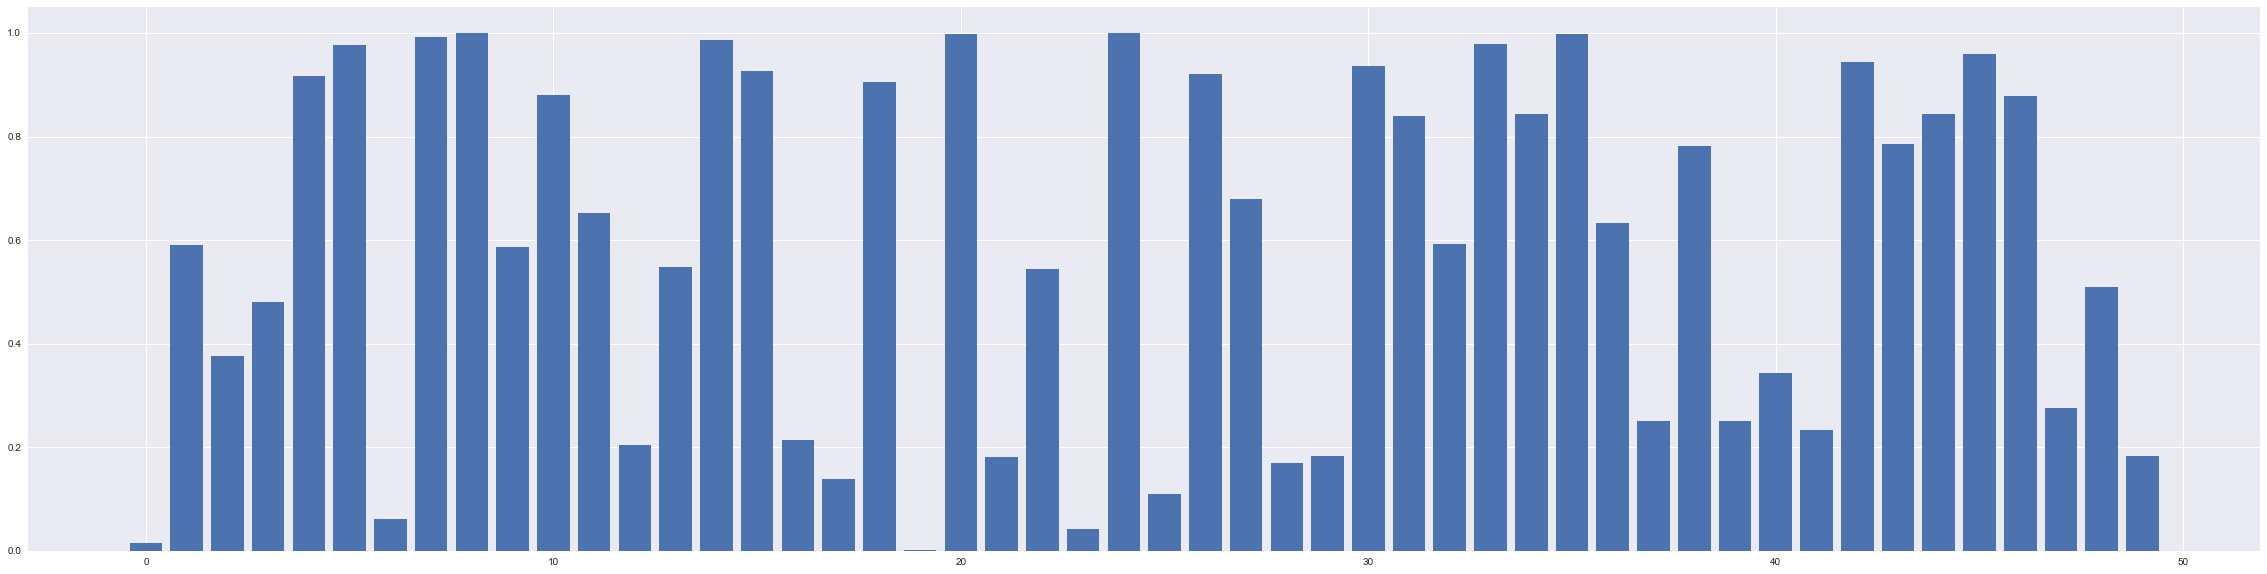

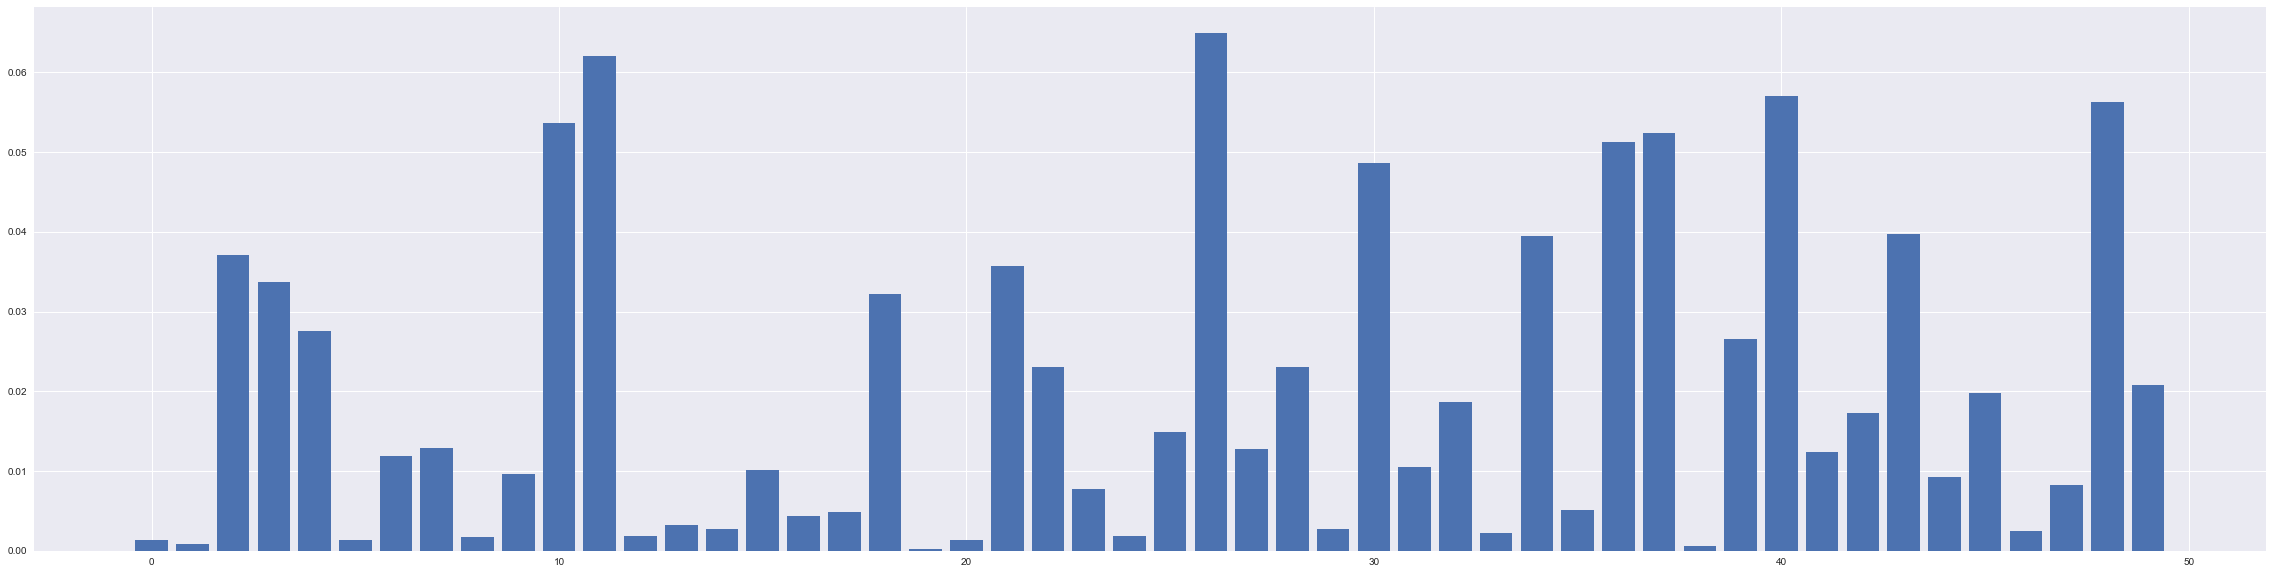

<Container object of 50 artists>

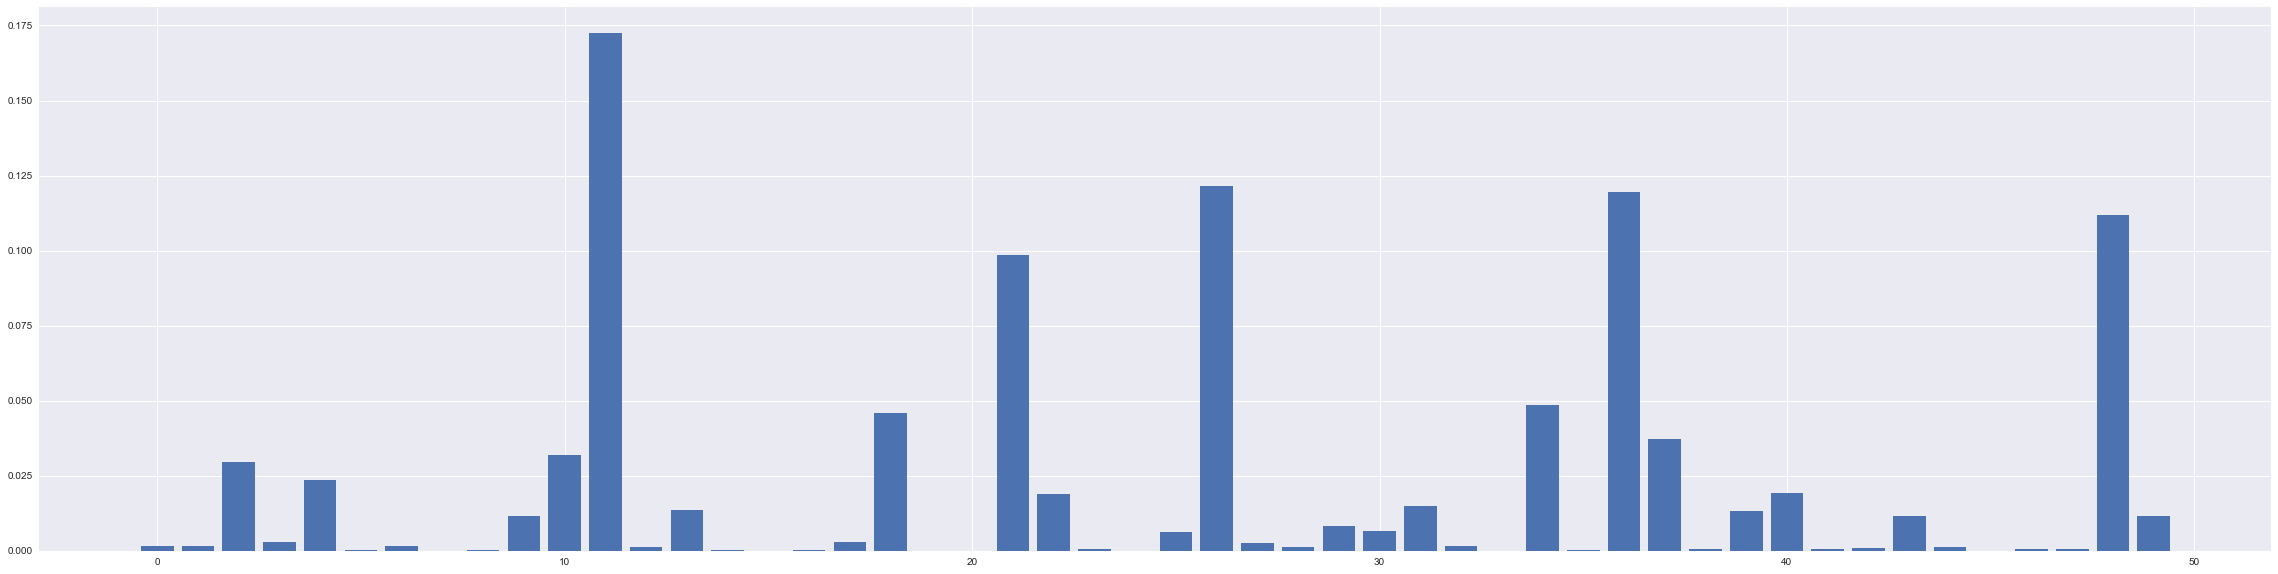

In [115]:
plt.bar(range(nc), [np.mean(np.array(target)[a == i]) for i in range(nc)])
plt.show()
plt.bar(range(nc), t1)
plt.show()
plt.bar(range(nc), t2)

In [116]:
nt = np.hstack([np.random.choice(np.array(newtrain.index)[a == i], size = int(np.sum(a == i)*t2[i]/t1[i]/max(np.array(t2)/np.array(t1)))) for i in range(nc)])

In [117]:
newtrain2 = newtrain.ix[nt]
target2 = target.ix[nt]

In [118]:
t10 = [np.sum(km.predict(np.array(newtrain2)) == i)/len(newtrain2) for i in range(nc)]
t20 = [np.sum(km.predict(np.array(newtest)) == i)/len(newtest) for i in range(nc)]

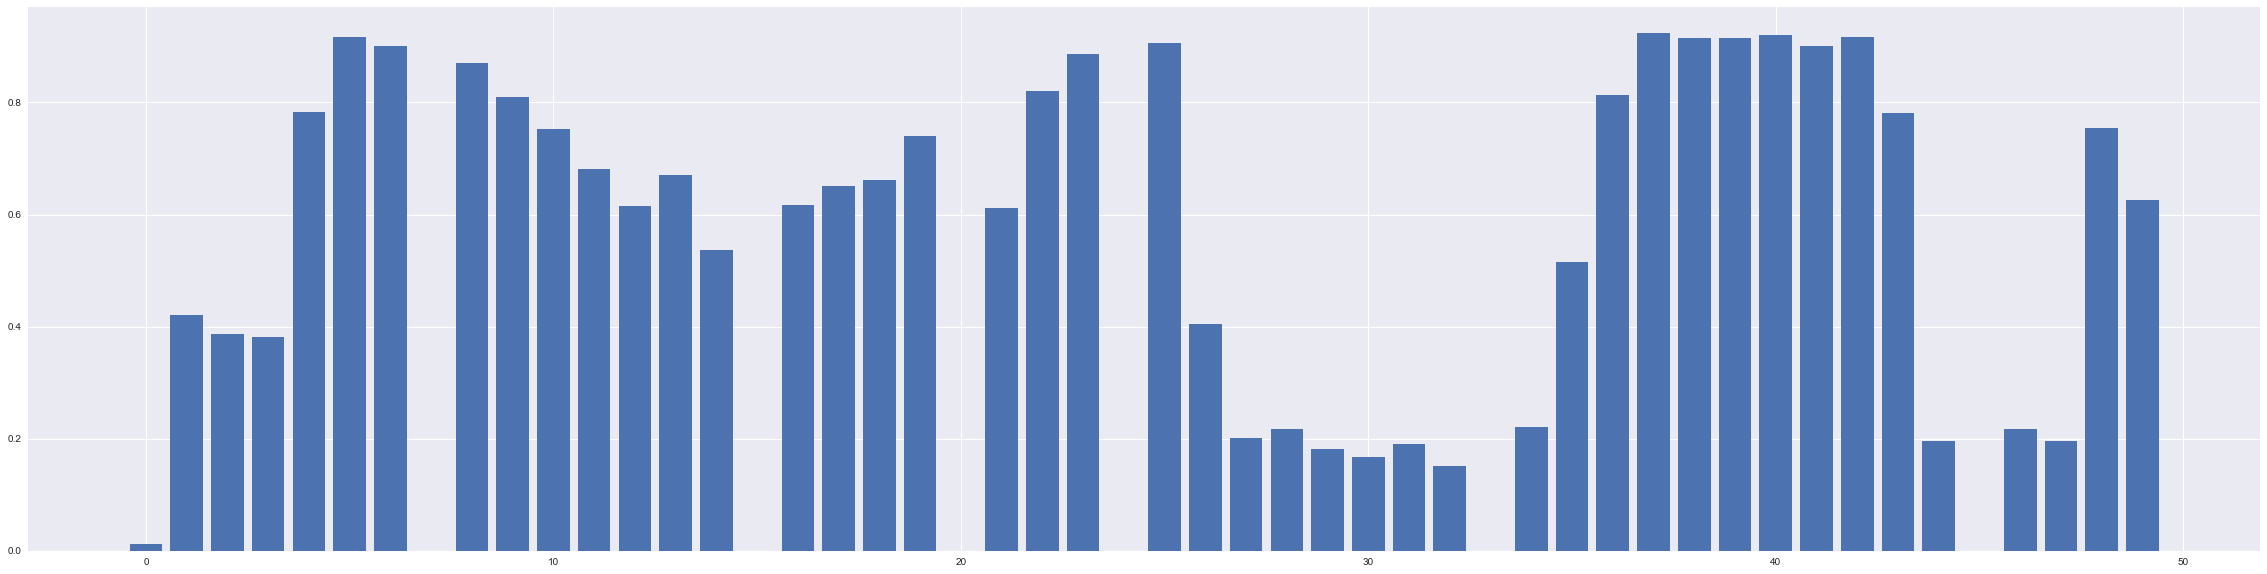

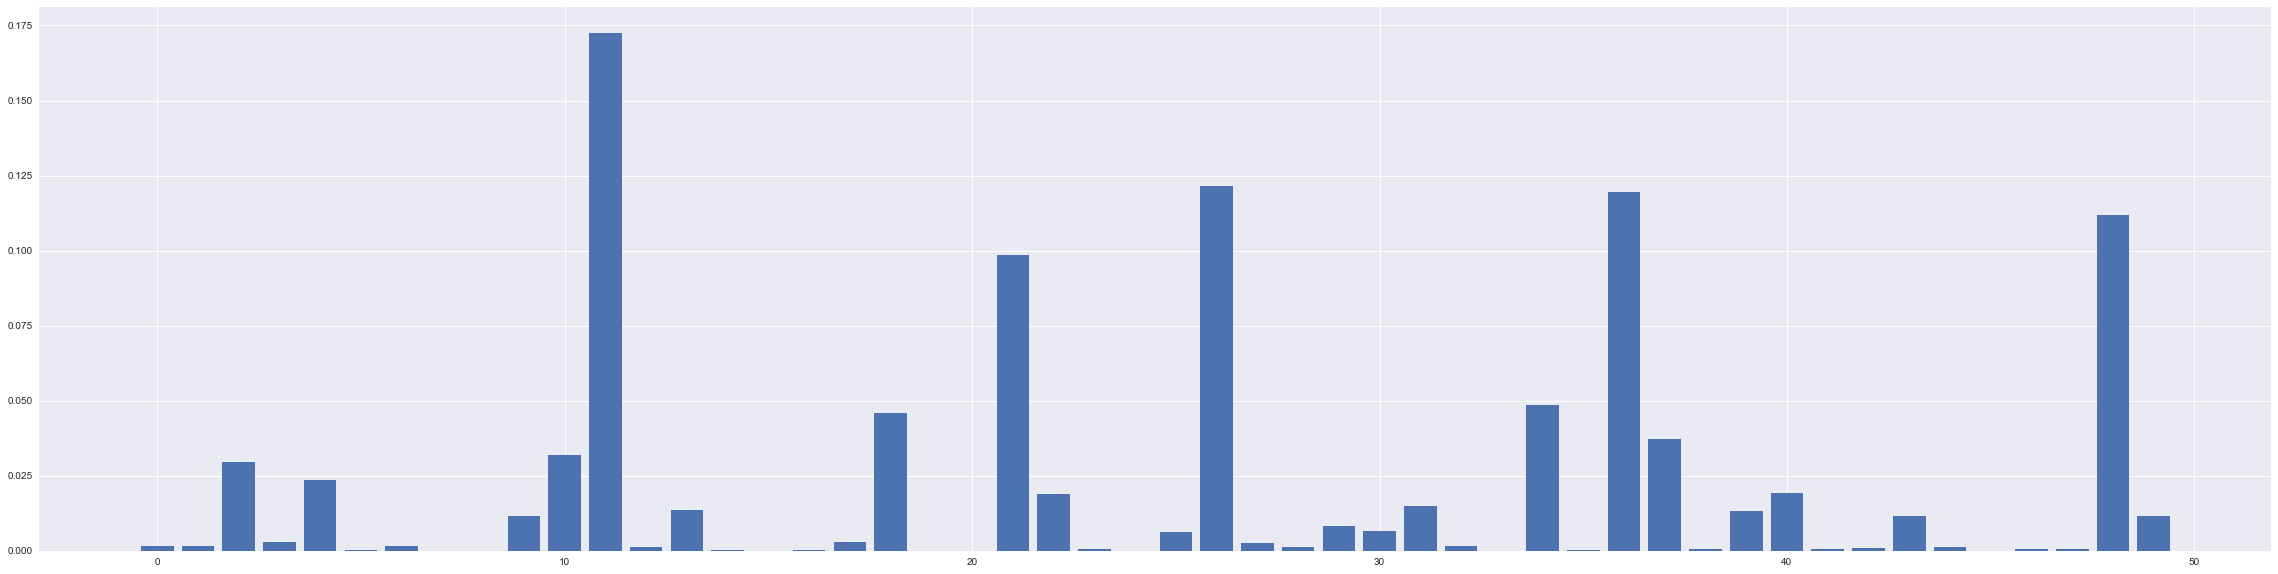

<Container object of 50 artists>

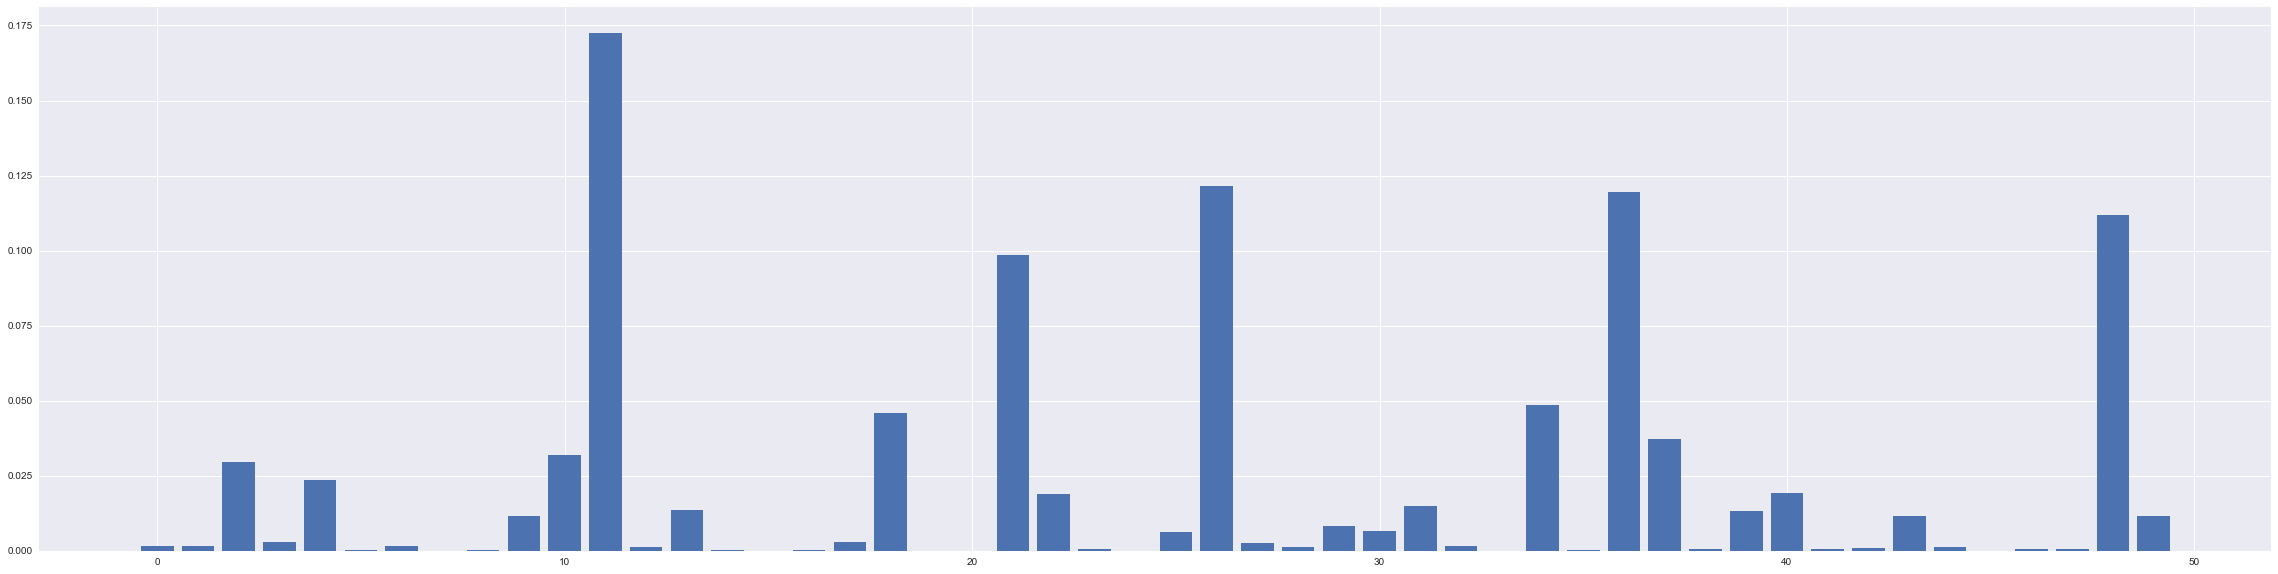

In [119]:
plt.bar(range(nc), [np.mean(np.array(target2.ix[nt])[km.predict(np.array(newtrain2)) == i]) for i in range(nc)])
plt.show()
plt.bar(range(nc), t10)
plt.show()
plt.bar(range(nc), t20)

In [120]:
newtrain2['cluster'] = km.predict(np.array(newtrain2))
newtest['cluster'] = km.predict(np.array(newtest))

In [121]:
newtrain2['is_listened'] = target2
avrg_cluster = newtrain2.groupby('cluster')['is_listened'].mean()
avrg_cluster.name = 'avrg_cluster'
newtrain2 = newtrain2.join(avrg_cluster, 'cluster', 'left', 'l')
newtest = newtest.join(avrg_cluster, 'cluster', 'left', 'l')

In [122]:
newtest['cluster'] = (newtest['cluster'] - np.mean(newtrain2['cluster']))/np.std(newtrain2['cluster'])
newtrain2['cluster'] = (newtrain2['cluster'] - np.mean(newtrain2['cluster']))/np.std(newtrain2['cluster'])
newtest['avrg_cluster'] = (newtest['avrg_cluster'] - np.mean(newtrain2['avrg_cluster']))/np.std(newtrain2['avrg_cluster'])
newtrain2['avrg_cluster'] = (newtrain2['avrg_cluster'] - np.mean(newtrain2['avrg_cluster']))/np.std(newtrain2['avrg_cluster'])

In [123]:
newtrain2.drop('is_listened', axis = 1, inplace = True)

## Remove elements with not enough values for flow and no flow

## A function to visualize the importance of the features

In [124]:
def importanceVisualisation(feature_importance, predictors, firstN = 40):
    
    plt.rcParams["figure.figsize"] = [40,10]
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.bar(pos[-firstN:], feature_importance[sorted_idx][-firstN:], align='center')
    plt.xticks(pos[-firstN:], predictors[sorted_idx][-firstN:], rotation='vertical')
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [125]:
from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 20,
          'learning_rate': 0.01, 'loss': 'huber', 'verbose':1, 'max_features': 20}
gbr = ensemble.GradientBoostingRegressor(**params)

In [126]:
index = np.random.choice(target.index, len(target)//10)

<h1> IV - 1. Gradient Boosting </h1>

In [127]:
# gbr.fit(newtrainlight.ix[index], target.ix[index])
gbr.fit(newtrain2, target2)

      Iter       Train Loss   Remaining Time 
         1           0.1955            9.28m
         2           0.1931            9.04m
         3           0.1907            9.04m
         4           0.1884            9.16m
         5           0.1862            9.15m
         6           0.1839            9.14m
         7           0.1817            9.16m
         8           0.1796            9.19m
         9           0.1775            9.17m
        10           0.1754            9.16m
        20           0.1567            9.13m
        30           0.1412            8.86m
        40           0.1283            8.64m
        50           0.1176            8.44m
        60           0.1088            8.25m
        70           0.1015            8.07m
        80           0.0953            7.89m
        90           0.0902            7.70m
       100           0.0860            7.51m
       200           0.0701            5.70m
       300           0.0674            3.78m
       40

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features=20, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)

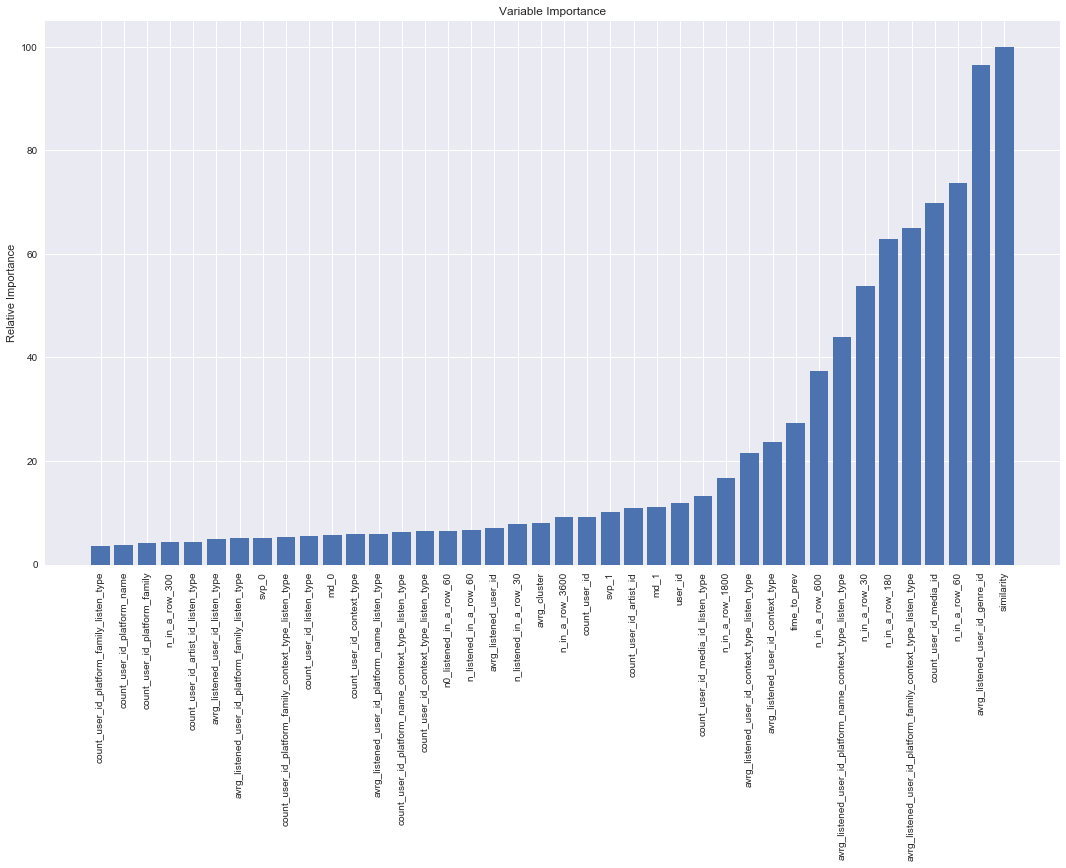

In [128]:
importanceVisualisation(gbr.feature_importances_, newtrain2.columns)

In [129]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target2, gbr.predict(newtrain2))

0.88437423260626691

In [130]:
newtrain2.columns[list(map(lambda x: x[0], sorted(list(enumerate(gbr.feature_importances_)), key=lambda x: x[1], reverse = True)))]

Index(['similarity', 'avrg_listened_user_id_genre_id', 'n_in_a_row_60',
       'count_user_id_media_id',
       'avrg_listened_user_id_platform_family_context_type_listen_type',
       'n_in_a_row_180', 'n_in_a_row_30',
       'avrg_listened_user_id_platform_name_context_type_listen_type',
       'n_in_a_row_600', 'time_to_prev', 'avrg_listened_user_id_context_type',
       'avrg_listened_user_id_context_type_listen_type', 'n_in_a_row_1800',
       'count_user_id_media_id_listen_type', 'user_id', 'md_1',
       'count_user_id_artist_id', 'svp_1', 'count_user_id', 'n_in_a_row_3600',
       'avrg_cluster', 'n_listened_in_a_row_30', 'avrg_listened_user_id',
       'n_listened_in_a_row_60', 'n0_listened_in_a_row_60',
       'count_user_id_context_type_listen_type',
       'count_user_id_platform_name_context_type_listen_type',
       'avrg_listened_user_id_platform_name_listen_type',
       'count_user_id_context_type', 'md_0', 'count_user_id_listen_type',
       'count_user_id_platform_fa

# Neural networks

In [91]:
# to_keep = newtrain.columns[[np.argsort(-gbr.feature_importances_)]][:26]
to_keep = ['ts_listen', 'release_date', 'media_duration', 'user_gender', 'user_age', 'similarity', 'count_user_id', 'avrg_listened_user_id', 'count_user_id_listen_type', 'avrg_listened_user_id_listen_type', 'count_user_id_artist_id', 'count_user_id_artist_id_listen_type', 'count_user_id_media_id', 'count_user_id_media_id_listen_type', 'count_user_id_genre_id', 'avrg_listened_user_id_genre_id', 'count_user_id_genre_id_listen_type', 'count_context_type', 'avrg_listened_context_type', 'count_context_type_listen_type', 'avrg_listened_context_type_listen_type', 'count_user_id_context_type', 'avrg_listened_user_id_context_type', 'count_user_id_context_type_listen_type', 'avrg_listened_user_id_context_type_listen_type', 'age_song', 'time_to_prev', 'n_in_a_row_30', 'n_in_a_row_60', 'n_in_a_row_180', 'n_in_a_row_300', 'n_in_a_row_600', 'n_in_a_row_1800', 'n_in_a_row_3600', 'n_in_a_row_43200', 'n_in_a_row_86400', 'n_listened_in_a_row_30', 'n_listened_in_a_row_60', 'n_listened_in_a_row_180', 'n_listened_in_a_row_300', 'n_listened_in_a_row_600', 'n_listened_in_a_row_1800', 'n_listened_in_a_row_3600', 'n_listened_in_a_row_43200', 'n_listened_in_a_row_86400', 'n0_listened_in_a_row_30', 'n0_listened_in_a_row_60', 'n0_listened_in_a_row_180', 'n0_listened_in_a_row_300', 'n0_listened_in_a_row_600', 'n0_listened_in_a_row_1800', 'n0_listened_in_a_row_3600', 'n0_listened_in_a_row_43200', 'n0_listened_in_a_row_86400', 'svp_0', 'svp_1', 'md_1', 'md_0', 'cluster', 'avrg_cluster']

newtrainlight, newtestlight = newtrain2[to_keep], newtest[to_keep]

In [92]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Embedding, Lambda
from keras.layers import Conv2D, MaxPooling2D, LSTM, Bidirectional, Input, Conv1D, concatenate, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K

In [93]:
def unison_shuffled_copies(a, b, useseed = False):
    assert len(a) == len(b)
    if useseed:
        np.random.seed(seed=23)
    p = np.random.permutation(len(a))
    return a[p], b[p], p

In [94]:
ntShuf, tShuf, _ = unison_shuffled_copies(np.array(newtrainlight), np.array(target2))

In [95]:
batch_size = 32
num_classes = 2
epochs = 5
len_train = int(.98*len(target2))

In [96]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = (ntShuf[:len_train], to_categorical(tShuf[:len_train], num_classes = num_classes)), (ntShuf[len_train:], to_categorical(tShuf[len_train:], num_classes = num_classes))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (488738, 60)
488738 train samples
9975 test samples


In [97]:
neural = Sequential()

### CHECK THAT THE PARAMETERS ARE CORRECTLY TUNED ###

dropout = .9

neural.add(Dense(x_train.shape[1], input_shape = x_train[0].shape))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('relu'))
neural.add(Dropout(dropout))
neural.add(Dense(x_train.shape[1]))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('relu'))
neural.add(Dropout(dropout))
neural.add(Dense(16))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('relu'))
neural.add(Dropout(dropout))
neural.add(Dense(num_classes))
neural.add(BatchNormalization(axis = -1))
neural.add(Activation('softmax'))


opt = keras.optimizers.rmsprop(lr=0.01, decay=1e-6)

In [98]:
from keras.callbacks import TensorBoard
# tensorboard --logdir=/tmp/charNN
# localhost:6006
# Let's train the model using RMSprop
neural.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

hist = neural.fit(x_train, y_train, epochs = epochs, validation_data = (x_test, y_test), batch_size = batch_size)

Train on 488738 samples, validate on 9975 samples
Epoch 1/5
488738/488738 [==============================] - 34s - loss: 0.6075 - acc: 0.6559 - val_loss: 0.5502 - val_acc: 0.6256
Epoch 2/5
488738/488738 [==============================] - 33s - loss: 0.5958 - acc: 0.6650 - val_loss: 0.5354 - val_acc: 0.7531
Epoch 3/5
488738/488738 [==============================] - 34s - loss: 0.5945 - acc: 0.6655 - val_loss: 0.5392 - val_acc: 0.7648
Epoch 4/5
488738/488738 [==============================] - 33s - loss: 0.5940 - acc: 0.6657 - val_loss: 0.5520 - val_acc: 0.6256
Epoch 5/5
488738/488738 [==============================] - 34s - loss: 0.5929 - acc: 0.6664 - val_loss: 0.5321 - val_acc: 0.7715


In [99]:
a = neural.predict_proba(x_test)

7584/9975 [=====================>........] - ETA: 0s

In [100]:
from sklearn.metrics import roc_auc_score
roc_auc_score(tShuf[len_train:], a[:, 1])

0.86210476521470503

In [101]:
newtrainlight.columns

Index(['ts_listen', 'release_date', 'media_duration', 'user_gender',
       'user_age', 'similarity', 'count_user_id', 'avrg_listened_user_id',
       'count_user_id_listen_type', 'avrg_listened_user_id_listen_type',
       'count_user_id_artist_id', 'count_user_id_artist_id_listen_type',
       'count_user_id_media_id', 'count_user_id_media_id_listen_type',
       'count_user_id_genre_id', 'avrg_listened_user_id_genre_id',
       'count_user_id_genre_id_listen_type', 'count_context_type',
       'avrg_listened_context_type', 'count_context_type_listen_type',
       'avrg_listened_context_type_listen_type', 'count_user_id_context_type',
       'avrg_listened_user_id_context_type',
       'count_user_id_context_type_listen_type',
       'avrg_listened_user_id_context_type_listen_type', 'age_song',
       'time_to_prev', 'n_in_a_row_30', 'n_in_a_row_60', 'n_in_a_row_180',
       'n_in_a_row_300', 'n_in_a_row_600', 'n_in_a_row_1800',
       'n_in_a_row_3600', 'n_in_a_row_43200', 'n_in_a_r

<h1> IV - 2. XGBoost </h1>

In [ ]:
from sklearn.model_selection import cross_val_predict

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50, plot = False):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target, verbose_eval = True, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    predicted_cv = cross_val_predict(alg, dtrain, target, cv = 5, n_jobs = -1)
    print('AUC Score (CV):',metrics.roc_auc_score(target, predicted_cv))
    
    if plot:
        importanceVisualisation(pd.Series(alg.booster().get_fscore()), predictors)

In [ ]:
predictors = newtrain.columns

## FIRST MODEL

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
#  nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, newtrain, predictors)

## GRID SEARCH ON XGBOOST TO FIND THE BEST PARAMETERS (VERY LONG)

## Grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test1 = {
#  'max_depth':np.array(range(3,10,2)),
#  'min_child_weight':np.array(range(1,6,2))
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch1.fit(newtrain[predictors],target)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## Finer grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test2 = {
#  'max_depth':[2,3,4],
#  'min_child_weight':[2,3,4]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch2.fit(newtrain[predictors],target)
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

## Grid search on 'gamma'

In [ ]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch3.fit(newtrain[predictors],target)
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

## Grid search on 'subsample' and 'colsample_bytree'

In [ ]:
# param_test4 = { 
#  'subsample':[i/10.0 for i in range(6,11)],
#  'colsample_bytree':[i/10.0 for i in range(6,11)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch4.fit(newtrain[predictors],target)
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

## Grid search on 'reg_alpha'

In [ ]:
# param_test6 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test6, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch6.fit(newtrain,target)
# gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
# param_test7 = {
#  'reg_alpha':[0.5,1,2,5,10]
# }
# gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test7, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch7.fit(newtrain,target)
# gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

## Grid search on 'learning_rate' and 'n_estimators'

In [209]:
param_test8 = {
 'learning_rate': [0.1,0.01,0.001],
 'n_estimators': [1000,5000,10000]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0, gamma=0.3, subsample=0.9, reg_alpha = 0.2, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=40), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(newtrain,target)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.80282, std: 0.00984, params: {'n_estimators': 1000, 'learning_rate': 0.1},
  mean: 0.80199, std: 0.01003, params: {'n_estimators': 5000, 'learning_rate': 0.1},
  mean: 0.80175, std: 0.01035, params: {'n_estimators': 10000, 'learning_rate': 0.1},
  mean: 0.81651, std: 0.00992, params: {'n_estimators': 1000, 'learning_rate': 0.01},
  mean: 0.80989, std: 0.00944, params: {'n_estimators': 5000, 'learning_rate': 0.01},
  mean: 0.80797, std: 0.00966, params: {'n_estimators': 10000, 'learning_rate': 0.01},
  mean: 0.81178, std: 0.00623, params: {'n_estimators': 1000, 'learning_rate': 0.001},
  mean: 0.81843, std: 0.00840, params: {'n_estimators': 5000, 'learning_rate': 0.001},
  mean: 0.81649, std: 0.00936, params: {'n_estimators': 10000, 'learning_rate': 0.001}],
 {'learning_rate': 0.001, 'n_estimators': 5000},
 0.8184288230374144)

## FINAL MODEL

In [28]:
# XgbParams = {'learning_rate': 0.001, 'n_estimators':10000, 'max_depth':6, 'min_child_weight':3, 'gamma':0,
#             'subsample':0.9, 'colsample_bytree':0.6, 'reg_alpha':1e-5, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

XgbParams = {'learning_rate': 0.001, 'n_estimators':1000, 'max_depth':5, 'min_child_weight':0, 'gamma':0.3,
            'subsample':0.9, 'colsample_bytree':0.9, 'reg_alpha':0.2, 'objective': 'binary:logistic',
             'nthread':-1, 'scale_pos_weight':1}

# XgbParams = {'learning_rate': 0.01, 'n_estimators':1000, 'max_depth':4, 'min_child_weight':4, 'gamma':0,
#             'subsample':1, 'colsample_bytree':0.6, 'reg_alpha':1, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

In [ ]:
xgb3 = XGBClassifier(**XgbParams, seed=27)
modelfit(xgb3, newtrain, predictors, plot = False)

In [216]:
xgb3 = XGBClassifier(**XgbParams, seed=40)
modelfit(xgb3, newtrain, predictors, plot = False)


Model Report
Accuracy : 0.7944
AUC Score (Train): 0.885769
AUC Score (CV): 0.721147862905


<h1> VI. Final Prediction </h1> (We take the best xgboost model here)

In [132]:
gbrpred = gbr.predict(newtest)
df_output = pd.DataFrame()
df_output['sample_id'] = IDtest
df_output['is_listened'] = gbrpred
df_output[['sample_id','is_listened']].to_csv('./predictions/GBRoutput.csv', sep = ",", index=False)

In [102]:
nnpred = neural.predict_proba(np.array(newtestlight))[:, 1]
df_output = pd.DataFrame()
df_output['sample_id'] = IDtest
df_output['is_listened'] = nnpred
df_output[['sample_id','is_listened']].to_csv('./predictions/NNoutput.csv', sep = ",", index=False)

19616/19918 [============================>.] - ETA:  - ETA: 0s